In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [30] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81]])

In [5]:
# convert max into min
c = - c

## Optimization Model 

In [6]:
ks_model = pyepo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-03-06


In [7]:
# solve
ks_model.setObj([-i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Obj: -265.0
40
43
44
45
46
47


In [8]:
# relax
ks_model_rel = ks_model.relax()

In [9]:
# solve
ks_model_rel.setObj([-i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9225932025752352, 0.0, 0.0, 1.0, 0.6333283425662526, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
Obj: -281.10241054050005
37
40
41
43
45
46
47


## Data Loader 

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [11]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [12]:
# get training data set
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 239.75it/s]


In [13]:
# get training data set for relaxation
ks_dataset_train_rel = pyepo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 869.34it/s]


In [14]:
# get test data set
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 228.63it/s]


In [15]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [16]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [17]:
x.shape

torch.Size([32, 5])

In [18]:
c.shape

torch.Size([32, 48])

In [19]:
w.shape

torch.Size([32, 48])

In [20]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [23]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [24]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [25]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.feats)

In [26]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.37it/s]


Normalized true SPO Loss: 12.45%
Normalized unambiguous SPO Loss: 12.45%


In [27]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 1.53, 4.22, 1.01, 0.43, 1.73, 0.37, 1.77, 1.53, 0.90, 1.17, 4.08, 1.57, 0.99, 4.51, 2.95, 1.91, 1.86, 1.74, 3.12, 2.99, 1.30, 0.98, 1.57, 0.53, 3.14, 2.77, 2.31, 3.00, 1.26, 1.70, 1.55, 1.49, 3.77, 1.11, 3.58, 3.87, 1.37, 3.00, 3.01, 1.12, 1.64, 3.89, 1.39, 3.84, 2.86, 1.17, 3.84, 1.32
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0

## Two-Stage with Grid Search 

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [29]:
# build model
twostage_model = pyepo.twostage.sklearnPred(Ridge())

In [30]:
# creat scorer
spo_scorer = pyepo.eval.metrics.makeSkScorer(ks_model)

In [31]:
# build grid search
grid = GridSearchCV(twostage_model, param_grid={'estimator__alpha': [0, 0.1, 0.5]}, scoring=spo_scorer)

In [32]:
# training
grid.fit(ks_dataset_train.feats, ks_dataset_train.costs)

GridSearchCV(estimator=MultiOutputRegressor(estimator=Ridge()),
             param_grid={'estimator__alpha': [0, 0.1, 0.5]},
             scoring=make_scorer(SPOError, greater_is_better=False, model_type=<class 'pyepo.model.grb.knapsack.knapsackModel'>, args={'weights': array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81]]), 'capacity': array([30, 30])}))

In [33]:
# prediction
c_test_pred = grid.predict(ks_dataset_test.feats)

In [34]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.34it/s]


Normalized true SPO Loss: 12.49%
Normalized unambiguous SPO Loss: 12.49%


In [35]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = grid.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 1.55, 4.22, 1.03, 0.45, 1.74, 0.39, 1.78, 1.54, 0.91, 1.19, 4.08, 1.58, 1.01, 4.51, 2.95, 1.93, 1.87, 1.75, 3.13, 2.99, 1.31, 1.00, 1.58, 0.55, 3.14, 2.78, 2.32, 3.00, 1.27, 1.70, 1.57, 1.51, 3.77, 1.13, 3.58, 3.87, 1.38, 3.01, 3.01, 1.14, 1.64, 3.89, 1.40, 3.84, 2.87, 1.18, 3.84, 1.33
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0

## Linear Regression from PyTorch

In [36]:
from torch import nn

In [37]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [38]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [39]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [40]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [41]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  55.4486, True SPO Loss: 41.0894%, Unambiguous SPO Loss: 41.0894%
Epoch  20, Loss:  26.7769, True SPO Loss: 36.1699%, Unambiguous SPO Loss: 36.1699%
Epoch  30, Loss:  64.7448, True SPO Loss: 29.5089%, Unambiguous SPO Loss: 29.5089%
Epoch  40, Loss:  35.5023, True SPO Loss: 23.8823%, Unambiguous SPO Loss: 23.8823%
Epoch  50, Loss:  34.4828, True SPO Loss: 20.4437%, Unambiguous SPO Loss: 20.4437%
Epoch  60, Loss:  49.4881, True SPO Loss: 18.2152%, Unambiguous SPO Loss: 18.2152%
Epoch  70, Loss:  19.6682, True SPO Loss: 17.4738%, Unambiguous SPO Loss: 17.4738%
Epoch  80, Loss:  13.2619, True SPO Loss: 16.6313%, Unambiguous SPO Loss: 16.6313%
Epoch  90, Loss:  29.1280, True SPO Loss: 15.6009%, Unambiguous SPO Loss: 15.6009%
Epoch 100, Loss:  30.5916, True SPO Loss: 14.8696%, Unambiguous SPO Loss: 14.8696%
Epoch 110, Loss:  51.6933, True SPO Loss: 14.2392%, Unambiguous SPO Loss: 14.2554%
Epoch 120, Loss:  44.9793, True SPO Loss: 14.1221%, Unambiguous SPO Loss: 14.1221%
Epoc

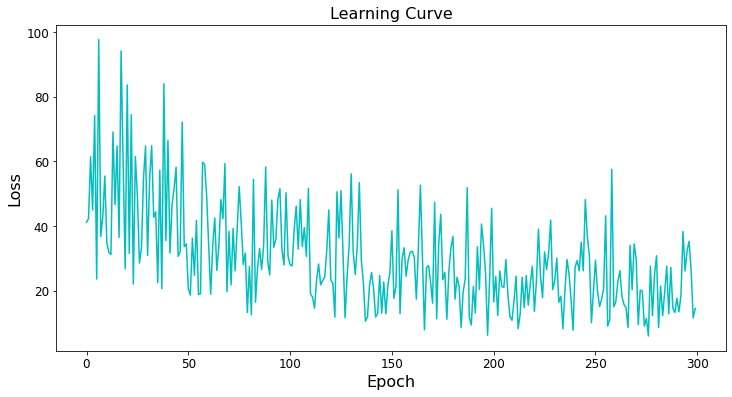

In [42]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Learning Curve', fontsize=16)
plt.show()

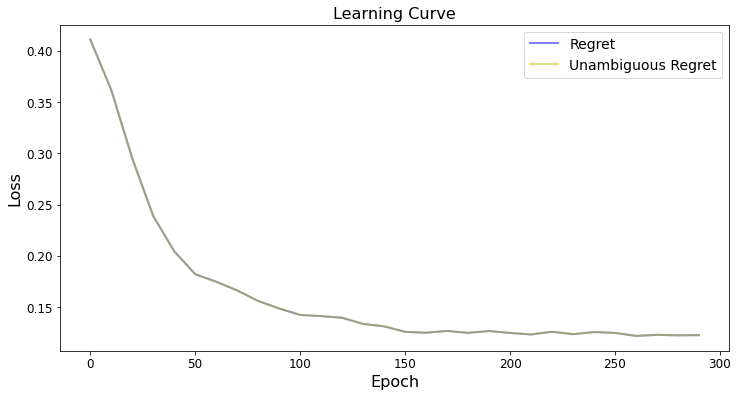

In [43]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=2, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=2, label='Unambiguous Regret')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Learning Curve', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [44]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 12.27%
Normalized unambiguous SPO Loss: 12.27%


In [45]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 1.04, 3.27, 0.20, 0.36, 1.02, -0.42, 1.67, 0.99, 1.47, 0.51, 3.24, 1.40, 0.64, 3.19, 2.37, 0.89, 1.99, 0.37, 1.84, 1.91, 0.68, -0.62, -0.14, -0.46, 2.10, 2.30, 1.47, 2.24, 1.19, 1.04, 0.86, 0.25, 2.90, 0.54, 2.52, 2.77, 1.35, 1.81, 2.22, 0.46, 0.96, 2.71, 0.58, 2.55, 1.75, 0.51, 3.19, 0.66
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj:

## SPO+ Rel 

In [46]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [47]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [48]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [49]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  33.8096, True SPO Loss: 43.6936%, Unambiguous SPO Loss: 43.6936%
Epoch  20, Loss:  68.5384, True SPO Loss: 34.6930%, Unambiguous SPO Loss: 34.6930%
Epoch  30, Loss:  27.8097, True SPO Loss: 29.0018%, Unambiguous SPO Loss: 29.0058%
Epoch  40, Loss:  39.0514, True SPO Loss: 23.6479%, Unambiguous SPO Loss: 23.6479%
Epoch  50, Loss:  49.6190, True SPO Loss: 20.7568%, Unambiguous SPO Loss: 20.7568%
Epoch  60, Loss:  76.6082, True SPO Loss: 19.1446%, Unambiguous SPO Loss: 19.1446%
Epoch  70, Loss:  43.4973, True SPO Loss: 17.7364%, Unambiguous SPO Loss: 17.7364%
Epoch  80, Loss:  30.6866, True SPO Loss: 16.7040%, Unambiguous SPO Loss: 16.7040%
Epoch  90, Loss:  42.2908, True SPO Loss: 15.5040%, Unambiguous SPO Loss: 15.5040%
Epoch 100, Loss:  16.2332, True SPO Loss: 14.8110%, Unambiguous SPO Loss: 14.8110%
Epoch 110, Loss:  42.2432, True SPO Loss: 14.1988%, Unambiguous SPO Loss: 14.1988%
Epoch 120, Loss:  37.8632, True SPO Loss: 13.8614%, Unambiguous SPO Loss: 13.8614%
Epoc

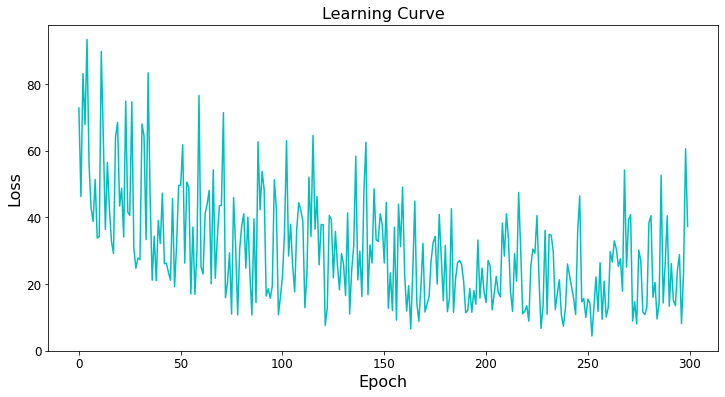

In [50]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Learning Curve', fontsize=16)
plt.show()

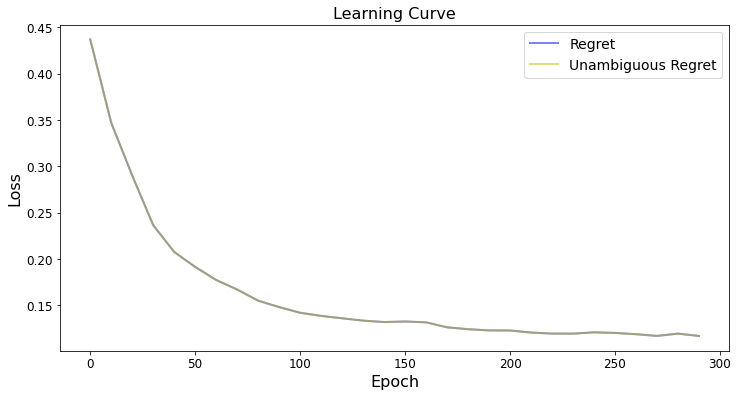

In [51]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=2, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=2, label='Unambiguous Regret')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Learning Curve', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [52]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 11.69%
Normalized unambiguous SPO Loss: 11.69%


In [53]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 0.08, 3.10, 0.33, -0.37, 1.30, -0.35, 1.61, -0.46, 1.42, 0.13, 3.46, -0.56, 0.53, 3.44, 2.63, 0.42, 1.53, 0.76, 2.36, 0.82, 0.84, 0.74, 1.84, 0.28, 2.79, 2.04, 1.59, 2.20, 1.10, 0.36, 1.23, 0.44, 2.47, 0.65, 2.52, 2.64, 0.24, 1.92, 2.50, 0.41, 0.99, 2.92, -0.05, 2.67, 1.37, 0.12, 3.03, 0.80
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: -0, 0, -0, 0, -0, 0, -0, 0, -0, -0, 1, 0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0

## Black-Box

In [54]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [55]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [56]:
# set loss
bb = pyepo.func.blackboxOpt(ks_model, lambd=20, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [57]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   3.2500, True SPO Loss: 24.1994%, Unambiguous SPO Loss: 24.1994%
Epoch  20, Loss:   4.2500, True SPO Loss: 15.3120%, Unambiguous SPO Loss: 15.3161%
Epoch  30, Loss:   2.5000, True SPO Loss: 14.0574%, Unambiguous SPO Loss: 14.0574%
Epoch  40, Loss:   7.7500, True SPO Loss: 14.5079%, Unambiguous SPO Loss: 14.5079%
Epoch  50, Loss:   4.7500, True SPO Loss: 14.5383%, Unambiguous SPO Loss: 14.5423%
Epoch  60, Loss:   7.7500, True SPO Loss: 14.3403%, Unambiguous SPO Loss: 14.3403%
Epoch  70, Loss:   4.5000, True SPO Loss: 14.3746%, Unambiguous SPO Loss: 14.3746%
Epoch  80, Loss:   1.7500, True SPO Loss: 15.3282%, Unambiguous SPO Loss: 15.3302%
Epoch  90, Loss:   9.5000, True SPO Loss: 15.8515%, Unambiguous SPO Loss: 15.8515%
Epoch 100, Loss:   4.2500, True SPO Loss: 15.5686%, Unambiguous SPO Loss: 15.5727%
Epoch 110, Loss:   2.5000, True SPO Loss: 15.7929%, Unambiguous SPO Loss: 15.7929%
Epoch 120, Loss:   6.7500, True SPO Loss: 17.2192%, Unambiguous SPO Loss: 17.2192%
Epoc

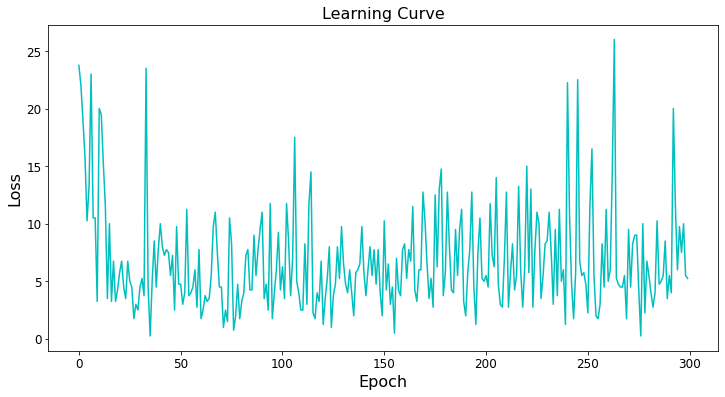

In [58]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Learning Curve', fontsize=16)
plt.show()

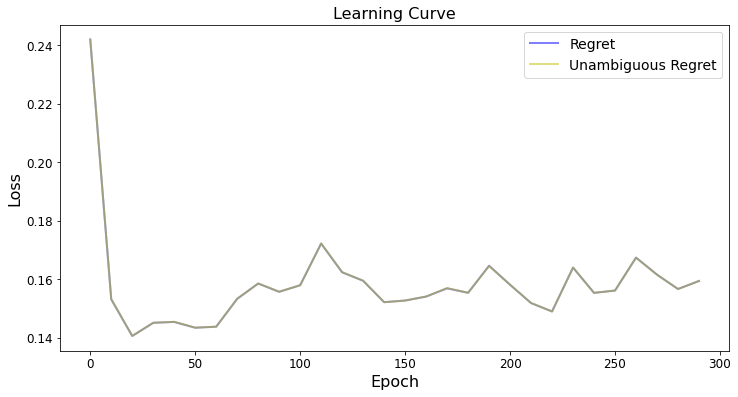

In [59]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=2, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=2, label='Unambiguous Regret')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Learning Curve', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [60]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 15.94%
Normalized unambiguous SPO Loss: 15.94%


In [61]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 0.04, 0.11, 0.01, -0.03, 0.02, -0.02, 0.03, -0.06, -0.56, 0.01, 0.07, -0.23, 0.05, 0.10, 0.08, -0.47, 0.01, -0.11, 0.06, -0.02, 0.04, -0.02, -0.37, 0.02, -0.05, 0.05, 0.04, 0.08, -0.18, 0.04, -0.07, 0.04, 0.10, 0.00, 0.08, 0.10, -0.05, 0.04, 0.00, 0.01, 0.05, 0.09, -0.04, 0.06, 0.05, 0.01, 0.10, 0.04
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0